<a href="https://colab.research.google.com/github/jspark9703/dlearningStudy/blob/twist/lab2/PT_Part2_Debiasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/MITDeepLearning/introtodeeplearning/blob/master/lab2/PT_Part2_Debiasing.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab2/PT_Part2_Debiasing.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [ ]:
# Copyright 2025 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 2: Computer Vision

# Part 2: Debiasing Facial Detection Systems

In the second portion of the lab, we'll explore two prominent aspects of applied deep learning: facial detection and algorithmic bias.

Deploying fair, unbiased AI systems is critical to their long-term acceptance. Consider the task of facial detection: given an image, is it an image of a face?  This seemingly simple, but extremely important, task is subject to significant amounts of algorithmic bias among select demographics.

In this lab, we'll investigate [one recently published approach](http://introtodeeplearning.com/AAAI_MitigatingAlgorithmicBias.pdf) to addressing algorithmic bias. We'll build a facial detection model that learns the *latent variables* underlying face image datasets and uses this to adaptively re-sample the training data, thus mitigating any biases that may be present in order  to train a *debiased* model.


Run the next code block for a short video from Google that explores how and why it's important to consider bias when thinking about machine learning:

Let's get started by installing the relevant dependencies.

We will be using Comet ML to track our model development and training runs.

1. Sign up for a Comet account: [HERE](https://www.comet.com/signup?utm_source=mit_dl&utm_medium=partner&utm_content=github)
2. This will generate a personal API Key, which you can find either in the first 'Get Started with Comet' page, under your account settings, or by pressing the '?' in the top right corner and then 'Quickstart Guide'. Enter this API key as the global variable `COMET_API_KEY` below.



In [4]:
## Comet ML
!pip install comet_ml --quiet
import comet_ml

# TODO: ENTER YOUR API KEY HERE!! instructions above
COMET_API_KEY = ""

# MIT introduction to deep learning package
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

In [5]:
import os
import random
import IPython
import functools
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn


# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    cudnn.benchmark = True
else:
  raise ValueError("GPU is not available. Change Colab runtime.")

ValueError: GPU is not available. Change Colab runtime.

## 2.1 Datasets

We'll be using three datasets in this lab. In order to train our facial detection models, we'll need a dataset of positive examples (i.e., of faces) and a dataset of negative examples (i.e., of things that are not faces). We'll use these data to train our models to classify images as either faces or not faces. Finally, we'll need a test dataset of face images. Since we're concerned about the potential *bias* of our learned models against certain demographics, it's important that the test dataset we use has equal representation across the demographics or features of interest. In this lab, we'll consider skin tone and gender.

1.   **Positive training data**: [CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). A large-scale (over 200K images) of celebrity faces.   
2.   **Negative training data**: [ImageNet](http://www.image-net.org/). Many images across many different categories. We'll take negative examples from a variety of non-human categories.
[Fitzpatrick Scale](https://en.wikipedia.org/wiki/Fitzpatrick_scale) skin type classification system, with each image labeled as "Lighter'' or "Darker''.

Let's begin by importing these datasets. We've written a class that does a bit of data pre-processing to import the training data in a usable format.

In [3]:
CACHE_DIR = Path.home() / ".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Get the training data: both images from CelebA and ImageNet
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")

# Create a simple check to avoid re-downloading
if path_to_training_data.is_file():
    print(f"Using cached training data from {path_to_training_data}")
else:
    print(f"Downloading training data to {path_to_training_data}")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)

# Instantiate a TrainingDatasetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(
    path_to_training_data, channels_last=channels_last
)

100%|██████████| 1.18G/1.18G [00:11<00:00, 110MB/s] 

Opening /root/.cache/mitdeeplearning/train_face.h5
Loading data into memory...


We can look at the size of the training dataset and grab a batch of size 100:

In [4]:
number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100)

In [5]:
B, C, H, W = images.shape

Play around with displaying images to get a sense of what the training data actually looks like!

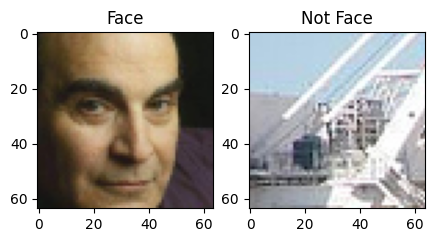

In [9]:
### Examining the CelebA training dataset ###

# @title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels == 1)[0]].transpose(0, 2, 3, 1)
not_face_images = images[np.where(labels == 0)[0]].transpose(0, 2, 3, 1)

idx_face = 7  # @param {type:"slider", min:0, max:50, step:1}
idx_not_face = 26  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.imshow(face_images[idx_face])
plt.title("Face")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(not_face_images[idx_not_face])
plt.title("Not Face")
plt.grid(False)

### Thinking about bias

Remember we'll be training our facial detection classifiers on the large, well-curated CelebA dataset (and ImageNet), and then evaluating their accuracy by testing them on an independent test dataset. Our goal is to build a model that trains on CelebA *and* achieves high classification accuracy on the the test dataset across all demographics, and to thus show that this model does not suffer from any hidden bias.

What exactly do we mean when we say a classifier is biased? In order to formalize this, we'll need to think about [*latent variables*](https://en.wikipedia.org/wiki/Latent_variable), variables that define a dataset but are not strictly observed. As defined in the generative modeling lecture, we'll use the term *latent space* to refer to the probability distributions of the aforementioned latent variables. Putting these ideas together, we consider a classifier *biased* if its classification decision changes after it sees some additional latent features. This notion of bias may be helpful to keep in mind throughout the rest of the lab.



```
# 코드로 형식 지정됨
```

## 2.2 CNN for facial detection

First, we'll define and train a CNN on the facial classification task, and evaluate its accuracy. Later, we'll evaluate the performance of our debiased models against this baseline CNN. The CNN model has a relatively standard architecture consisting of a series of convolutional layers with batch normalization followed by two fully connected layers to flatten the convolution output and generate a class prediction.

### Define and train the CNN model

Like we did in the first part of the lab, we'll define our CNN model, and then train on the CelebA and ImageNet datasets by leveraging PyTorch's automatic differentiation (`torch.autograd`) by using the `loss.backward()` and `optimizer.step()` functions.

In [10]:
### Define the CNN model ###

n_filters = 12  # base number of convolutional filters
in_channels = images.shape[1]

def make_standard_classifier(n_outputs):
  """Create a standard CNN classifier."""

  # Start by first defining a convolutional block
  class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        return x

  # now use the block to define the classifier
  model = nn.Sequential(
      ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
      ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2),
      ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1),
      ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1),
      nn.Flatten(),
      nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512, n_outputs),
  )

  return model.to(device)

# call the function to instantiate a classifier model
standard_classifier = make_standard_classifier(n_outputs=1)
print(standard_classifier)

Sequential(
  (0): ConvBlock(
    (conv): Conv2d(3, 12, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): ConvBlock(
    (conv): Conv2d(12, 24, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ConvBlock(
    (conv): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): ConvBlock(
    (conv): Conv2d(48, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1152, out_features=512, bias=True)
  (6

Now let's train the standard CNN!

In [11]:
from google.colab import userdata
COMET_API_KEY = userdata.get('COMET_API_KEY')

In [12]:
### Create a Comet experiment to track our training run ###
def create_experiment(project_name, params):
    # end any prior experiments
    if "experiment" in locals():
        experiment.end()

    # initiate the comet experiment for tracking
    experiment = comet_ml.Experiment(api_key=COMET_API_KEY, project_name=project_name)
    # log our hyperparameters, defined above, to the experiment
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()

    return experiment


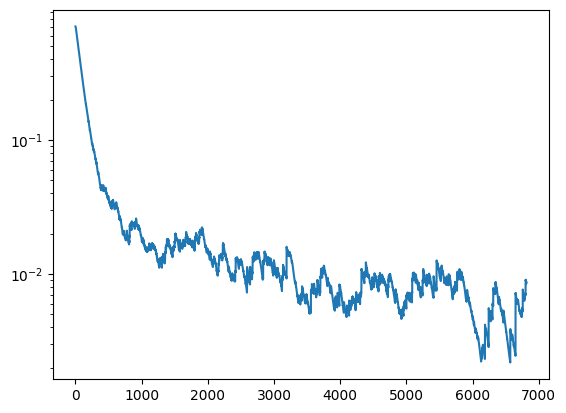

100%|██████████| 3434/3434 [00:34<00:00, 100.85it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : above_breezeway_2543
COMET INFO:     url                   : https://www.comet.com/jspark9703/6s191-lab2-part2-cnn/9081a1881dd146c2ae586ddc8e6bd546
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (1.4212099586075055e-07, 0.7035102844238281)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2Fjspark9703%2FdlearningStudy%2Fblob%2Fmain%2Flab2%2FPT_Part2_Debiasing.ipynb
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0005
COMET INFO:     num_epochs    : 2


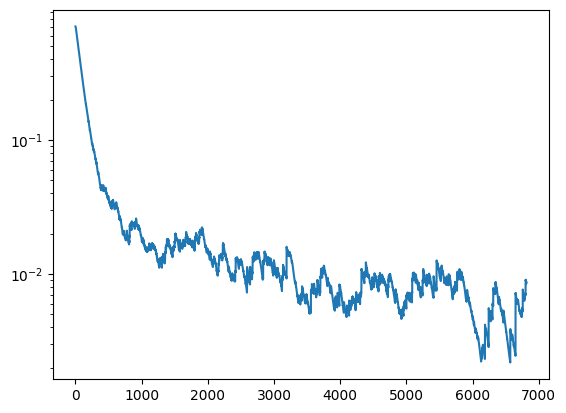

In [13]:
### Train the standard CNN ###
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)

experiment = create_experiment("6S191_Lab2_Part2_CNN", params)

optimizer = optim.Adam(
    standard_classifier.parameters(), lr=params["learning_rate"]
)  # define our optimizer
loss_history = mdl.util.LossHistory(smoothing_factor=0.99)  # to record loss evolution
plotter = mdl.util.PeriodicPlotter(sec=2, scale="semilogy")
if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()  # clear if it exists

# set the model to train mode
standard_classifier.train()


def standard_train_step(x, y):
    x = torch.from_numpy(x).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # clear the gradients
    optimizer.zero_grad()

    # feed the images into the model
    logits = standard_classifier(x)
    # Compute the loss
    loss = loss_fn(logits, y)

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss


# The training loop!
step = 0
for epoch in range(params["num_epochs"]):
    for idx in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # Grab a batch of training data and propagate through the network
        x, y = loader.get_batch(params["batch_size"])
        loss = standard_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()

        # Record the loss and plot the evolution of the loss as a function of training
        loss_history.append(loss_value)
        plotter.plot(loss_history.get())

        experiment.log_metric("loss", loss_value, step=step)
        step += 1

experiment.end()

### Evaluate performance of the standard CNN

Next, let's evaluate the classification performance of our CelebA-trained standard CNN on the training dataset.


In [14]:
### Evaluation of standard CNN ###

# set the model to eval mode
standard_classifier.eval()

# TRAINING DATA
# Evaluate on a subset of CelebA+Imagenet
(batch_x, batch_y) = loader.get_batch(5000)
batch_x = torch.from_numpy(batch_x).float().to(device)
batch_y = torch.from_numpy(batch_y).float().to(device)

with torch.inference_mode():
    y_pred_logits = standard_classifier(batch_x)
    y_pred_standard = torch.round(torch.sigmoid(y_pred_logits))
    acc_standard = torch.mean((batch_y == y_pred_standard).float())

print(
    "Standard CNN accuracy on (potentially biased) training set: {:.4f}".format(
        acc_standard.item()
    )
)

Standard CNN accuracy on (potentially biased) training set: 0.9964


We will also evaluate our networks on an independent test dataset containing faces that were not seen during training. For the test data, we'll look at the classification accuracy across four different demographics, based on the Fitzpatrick skin scale and sex-based labels: dark-skinned male, dark-skinned female, light-skinned male, and light-skinned female.

Let's take a look at some sample faces in the test set.

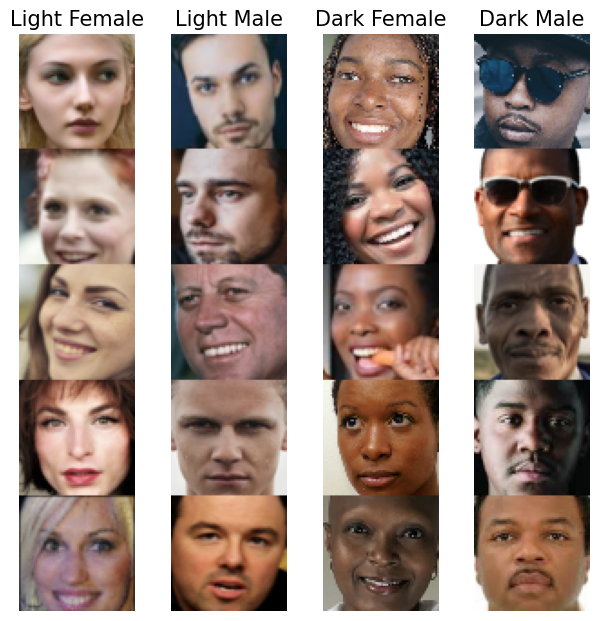

In [15]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces(channels_last=channels_last)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")


Now, let's evaluate the probability of each of these face demographics being classified as a face using the standard CNN classifier we've just trained.

Text(0.5, 1.0, 'Standard classifier predictions')

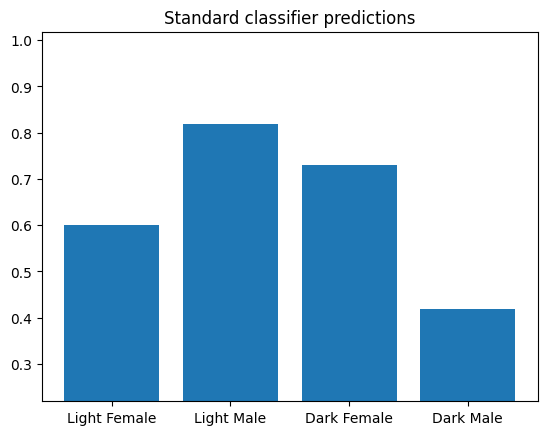

In [16]:
### Evaluate the standard CNN on the test data ###

standard_classifier_probs_list = []  # store each demographic's probabilities

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = standard_classifier(x)  # [B, 1]
        probs = torch.sigmoid(logits)  # [B, 1]
        probs = torch.squeeze(probs, dim=-1)  # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)


# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)  # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

Take a look at the accuracies for this first model across these four groups. What do you observe? Would you consider this model biased or unbiased? What are some reasons why a trained model may have biased accuracies?

## 2.3 Mitigating algorithmic bias

Imbalances in the training data can result in unwanted algorithmic bias. For example, the majority of faces in CelebA (our training set) are those of light-skinned females. As a result, a classifier trained on CelebA will be better suited at recognizing and classifying faces with features similar to these, and will thus be biased.

How could we overcome this? A naive solution -- and one that is being adopted by many companies and organizations -- would be to annotate different subclasses (i.e., light-skinned females, males with hats, etc.) within the training data, and then manually even out the data with respect to these groups.

But this approach has two major disadvantages. First, it requires annotating massive amounts of data, which is not scalable. Second, it requires that we know what potential biases (e.g., race, gender, pose, occlusion, hats, glasses, etc.) to look for in the data. As a result, manual annotation may not capture all the different features that are imbalanced within the training data.

Instead, let's actually **learn** these features in an unbiased, unsupervised manner, without the need for any annotation, and then train a classifier fairly with respect to these features. In the rest of this lab, we'll do exactly that.

## 2.4 Variational autoencoder (VAE) for learning latent structure

As you saw, the accuracy of the CNN varies across the four demographics we looked at. To think about why this may be, consider the dataset the model was trained on, CelebA. If certain features, such as dark skin or hats, are *rare* in CelebA, the model may end up biased against these as a result of training with a biased dataset. That is to say, its classification accuracy will be worse on faces that have under-represented features, such as dark-skinned faces or faces with hats, relevative to faces with features well-represented in the training data! This is a problem.

Our goal is to train a *debiased* version of this classifier -- one that accounts for potential disparities in feature representation within the training data. Specifically, to build a debiased facial classifier, we'll train a model that **learns a representation of the underlying latent space** to the face training data. The model then uses this information to mitigate unwanted biases by sampling faces with rare features, like dark skin or hats, *more frequently* during training. The key design requirement for our model is that it can learn an *encoding* of the latent features in the face data in an entirely *unsupervised* way. To achieve this, we'll turn to variational autoencoders (VAEs).

![The concept of a VAE](https://i.ibb.co/3s4S6Gc/vae.jpg)

As shown in the schematic above and in Lecture 4, VAEs rely on an encoder-decoder structure to learn a latent representation of the input data. In the context of computer vision, the encoder network takes in input images, encodes them into a series of variables defined by a mean and standard deviation, and then draws from the distributions defined by these parameters to generate a set of sampled latent variables. The decoder network then "decodes" these variables to generate a reconstruction of the original image, which is used during training to help the model identify which latent variables are important to learn.

Let's formalize two key aspects of the VAE model and define relevant functions for each.


### Understanding VAEs: loss function

In practice, how can we train a VAE? In learning the latent space, we constrain the means and standard deviations to approximately follow a unit Gaussian. Recall that these are learned parameters, and therefore must factor into the loss computation, and that the decoder portion of the VAE is using these parameters to output a reconstruction that should closely match the input image, which also must factor into the loss. What this means is that we'll have two terms in our VAE loss function:

1.  **Latent loss ($L_{KL}$)**: measures how closely the learned latent variables match a unit Gaussian and is defined by the Kullback-Leibler (KL) divergence.
2.   **Reconstruction loss ($L_{x}{(x,\hat{x})}$)**: measures how accurately the reconstructed outputs match the input and is given by the $L^1$ norm of the input image and its reconstructed output.

The equation for the latent loss is provided by:

$$L_{KL}(\mu, \sigma) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j + \mu_j^2 - 1 - \log{\sigma_j})$$

The equation for the reconstruction loss is provided by:

$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

Thus for the VAE loss we have:

$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

where $c$ is a weighting coefficient used for regularization. Now we're ready to define our VAE loss function:

In [17]:
### Defining the VAE loss function ###

""" Function to calculate VAE loss given:
      an input x,
      reconstructed output x_recon,
      encoded means mu,
      encoded log of standard deviation logsigma,
      weight parameter for the latent loss kl_weight
"""
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    # TODO: Define the latent loss. Note this is given in the equation for L_{KL}
    # in the text block directly above
    latent_loss = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - torch.exp(2 * logsigma), dim=1)
    latent_loss = torch.mean(latent_loss)
    # TODO: Define the reconstruction loss as the mean absolute pixel-wise
    # difference between the input and reconstruction. Hint: you'll need to
    # use torch.mean, and specify the dimensions to reduce over.
    # For example, reconstruction loss needs to average
    # over the height, width, and channel image dimensions.
    # https://pytorch.org/docs/stable/generated/torch.mean.html
    reconstruction_loss = torch.mean(torch.abs(x - x_recon))
    # TODO: Define the VAE loss. Note this is given in the equation for L_{VAE}
    # in the text block directly above
    vae_loss =reconstruction_loss + kl_weight * latent_loss

    return vae_loss

Great! Now that we have a more concrete sense of how VAEs work, let's explore how we can leverage this network structure to train a *debiased* facial classifier.

### Understanding VAEs: reparameterization

As you may recall from lecture, VAEs use a "reparameterization  trick" for sampling learned latent variables. Instead of the VAE encoder generating a single vector of real numbers for each latent variable, it generates a vector of means and a vector of standard deviations that are constrained to roughly follow Gaussian distributions. We then sample from the standard deviations and add back the mean to output this as our sampled latent vector. Formalizing this for a latent variable $z$ where we sample $\epsilon \sim N(0,(I))$ we have:

$$z = \mu + e^{\left(\frac{1}{2} \cdot \log{\Sigma}\right)}\circ \epsilon$$

where $\mu$ is the mean and $\Sigma$ is the covariance matrix. This is useful because it will let us neatly define the loss function for the VAE, generate randomly sampled latent variables, achieve improved network generalization, **and** make our complete VAE network differentiable so that it can be trained via backpropagation. Quite powerful!

Let's define a function to implement the VAE sampling operation:

In [18]:
### VAE Reparameterization ###

"""Reparameterization trick by sampling from an isotropic unit Gaussian.
# Arguments
    z_mean, z_logsigma (tensor): mean and log of standard deviation of latent distribution (Q(z|X))
# Returns
    z (tensor): sampled latent vector
"""
def sampling(z_mean, z_logsigma):
    # Generate random noise with the same shape as z_mean, sampled from a standard normal distribution (mean=0, std=1)
    eps = torch.randn_like(z_mean)

    # # TODO: Define the reparameterization computation!
    # # Note the equation is given in the text block immediately above.
    z = z_mean + torch.exp(z_logsigma) * eps

    return z

## 2.5 Debiasing variational autoencoder (DB-VAE)

Now, we'll use the general idea behind the VAE architecture to build a model, termed a [*debiasing variational autoencoder*](https://lmrt.mit.edu/sites/default/files/AIES-19_paper_220.pdf) or DB-VAE, to mitigate (potentially) unknown biases present within the training idea. We'll train our DB-VAE model on the facial detection task, run the debiasing operation during training, evaluate on the PPB dataset, and compare its accuracy to our original, biased CNN model.    

### The DB-VAE model

The key idea behind this debiasing approach is to use the latent variables learned via a VAE to adaptively re-sample the CelebA data during training. Specifically, we will alter the probability that a given image is used during training based on how often its latent features appear in the dataset. So, faces with rarer features (like dark skin, sunglasses, or hats) should become more likely to be sampled during training, while the sampling probability for faces with features that are over-represented in the training dataset should decrease (relative to uniform random sampling across the training data).

A general schematic of the DB-VAE approach is shown here:

![DB-VAE](https://raw.githubusercontent.com/MITDeepLearning/introtodeeplearning/2019/lab2/img/DB-VAE.png)

Recall that we want to apply our DB-VAE to a *supervised classification* problem -- the facial detection task. Importantly, note how the encoder portion in the DB-VAE architecture also outputs a single supervised variable, $z_o$, corresponding to the class prediction -- face or not face. Usually, VAEs are not trained to output any supervised variables (such as a class prediction)! This is another key distinction between the DB-VAE and a traditional VAE.

Keep in mind that we only want to learn the latent representation of *faces*, as that's what we're ultimately debiasing against, even though we are training a model on a binary classification problem. We'll need to ensure that, **for faces**, our DB-VAE model both learns a representation of the unsupervised latent variables, captured by the distribution $q_\phi(z|x)$, **and** outputs a supervised class prediction $z_o$, but that, **for negative examples**, it only outputs a class prediction $z_o$.

### Defining the DB-VAE loss function

This means we'll need to be a bit clever about the loss function for the DB-VAE. The form of the loss will depend on whether it's a face image or a non-face image that's being considered.

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem.

In contrast, for images of **non-faces**, our loss function is solely the classification loss.

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

Let's write a function to define the DB-VAE loss function:


In [19]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_pred: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    y = y.float()
    face_indicator = (y == 1.0).float()

    vae_loss = vae_loss_function(x, x_pred, mu, logsigma) # TODO

    # TODO: define the classification loss using binary_cross_entropy
    # https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html
    classification_loss = F.binary_cross_entropy_with_logits(y_logit.squeeze(), y.squeeze())


    total_loss = torch.mean(classification_loss + face_indicator * vae_loss)

    return total_loss, classification_loss

### DB-VAE architecture

Now we're ready to define the DB-VAE architecture. To build the DB-VAE, we will use the standard CNN classifier from above as our encoder, and then define a decoder network. We will create and initialize the two models, and then construct the end-to-end VAE. We will use a latent space with 100 latent variables.

The decoder network will take as input the sampled latent variables, run them through a series of deconvolutional layers, and output a reconstruction of the original input image.

In [20]:
### Define the decoder portion of the DB-VAE ###

n_filters = 12  # base number of convolutional filters, same as standard CNN
latent_dim = 100  # number of latent variables


def make_face_decoder_network(latent_dim=100, n_filters=12):
    """
    Function builds a face-decoder network.

    Args:
        latent_dim (int): the dimension of the latent representation
        n_filters (int): base number of convolutional filters

    Returns:
        decoder_model (nn.Module): the decoder network
    """

    class FaceDecoder(nn.Module):
        def __init__(self, latent_dim, n_filters):
            super(FaceDecoder, self).__init__()

            self.latent_dim = latent_dim
            self.n_filters = n_filters

            # Linear (fully connected) layer to project from latent space
            # to a 4 x 4 feature map with (6*n_filters) channels
            self.linear = nn.Sequential(
                nn.Linear(latent_dim, 4 * 4 * 6 * n_filters), nn.ReLU()
            )

            # Convolutional upsampling (inverse of an encoder)
            self.deconv = nn.Sequential(
                # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
                nn.ConvTranspose2d(
                    in_channels=6 * n_filters,
                    out_channels=4 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
                nn.ConvTranspose2d(
                    in_channels=4 * n_filters,
                    out_channels=2 * n_filters,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
                nn.ConvTranspose2d(
                    in_channels=2 * n_filters,
                    out_channels=n_filters,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
                nn.ReLU(),
                # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
                nn.ConvTranspose2d(
                    in_channels=n_filters,
                    out_channels=3,
                    kernel_size=5,
                    stride=2,
                    padding=2,
                    output_padding=1,
                ),
            )

        def forward(self, z):
            """
            Forward pass of the decoder.

            Args:
                z (Tensor): Latent codes of shape [batch_size, latent_dim].

            Returns:
                Tensor of shape [batch_size, 3, 64, 64], representing
                the reconstructed images.
            """
            x = self.linear(z)  # [B, 4*4*6*n_filters]
            x = x.view(-1, 6 * self.n_filters, 4, 4)  # [B, 6n_filters, 4, 4]

            # Upsample through transposed convolutions
            x = self.deconv(x)  # [B, 3, 64, 64]
            return x

    return FaceDecoder(latent_dim, n_filters)

Now, we will put this decoder together with the standard CNN classifier as our encoder to define the DB-VAE. Note that at this point, there is nothing special about how we put the model together that makes it a "debiasing" model -- that will come when we define the training operation. Here, we will define the core VAE architecture by sublassing `nn.Module` class; defining encoding, reparameterization, and decoding operations; and calling the network end-to-end.

In [21]:
### Defining and creating the DB-VAE ###


class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder.
        self.encoder = make_standard_classifier(n_outputs=2 * latent_dim + 1)
        self.decoder = make_face_decoder_network()

    # function to feed images into encoder, encode the latent space, and output
    def encode(self, x):
        encoder_output = self.encoder(x)

        # classification prediction
        y_logit = encoder_output[:, 0].unsqueeze(-1)
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1 : self.latent_dim + 1]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]

        return y_logit, z_mean, z_logsigma

    # VAE reparameterization: given a mean and logsigma, sample latent variables
    def reparameterize(self, z_mean, z_logsigma):
        # TODO: call the sampling function defined above
        z = sampling(z_mean, z_logsigma)
        return z

    # Decode the latent space and output reconstruction
    def decode(self, z):
        # TODO: use the decoder to output the reconstruction
        reconstruction = self.decoder(z)
        return reconstruction

    # The forward function will be used to pass inputs x through the core VAE
    def forward(self, x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)

        # TODO: reparameterization
        z = self.reparameterize(z_mean, z_logsigma)

        # TODO: reconstruction
        recon = self.decode(z)

        return y_logit, z_mean, z_logsigma, recon

    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

dbvae = DB_VAE(latent_dim)

As stated, the encoder architecture is identical to the CNN from earlier in this lab. Note the outputs of our constructed DB_VAE model in the `forward` function: `y_logit, z_mean, z_logsigma, z`. Think carefully about why each of these are outputted and their significance to the problem at hand.



### Adaptive resampling for automated debiasing with DB-VAE

So, how can we actually use DB-VAE to train a debiased facial detection classifier?

Recall the DB-VAE architecture: as input images are fed through the network, the encoder learns an estimate ${Q}(z|X)$ of the latent space. We want to increase the relative frequency of rare data by increased sampling of under-represented regions of the latent space. We can approximate ${Q}(z|X)$ using the frequency distributions of each of the learned latent variables, and then define the probability distribution of selecting a given datapoint $x$ based on this approximation. These probability distributions will be used during training to re-sample the data.

You'll write a function to execute this update of the sampling probabilities, and then call this function within the DB-VAE training loop to actually debias the model.

First, we've defined a short helper function `get_latent_mu` that returns the latent variable means returned by the encoder after a batch of images is inputted to the network:

In [22]:
# Function to return the means for an input image batch

def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []

    # If images is NumPy, convert once outside the loop
    images_t = torch.from_numpy(images).float()

    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to(device).permute(0, 3, 1, 2)
            # Forward pass on this chunk only
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu())

    # Concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0)  # shape [N, latent_dim]
    mu = z_mean_full.numpy()  # convert to NumPy if needed
    return mu

Now, let's define the actual resampling algorithm `get_training_sample_probabilities`. Importantly note the argument `smoothing_fac`. This parameter tunes the degree of debiasing: for `smoothing_fac=0`, the re-sampled training set will tend towards falling uniformly over the latent space, i.e., the most extreme debiasing.

In [23]:
### Resampling algorithm for DB-VAE ###

"""Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data"""
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    # TODO: run the input batch and get the latent variable means
    mu = get_latent_mu(images, dbvae) # TODO

    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64)

    # consider the distribution for each latent variable
    for i in range(latent_dim):
        latent_distribution = mu[:, i]
        # generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )

        # find which latent bin every data sample falls in
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")

        # TODO: call the digitize function to find which bins in the latent distribution
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # invert the density function
        p = 1.0 / (hist_smoothed_density[bin_idx - 1])

        # TODO: normalize all probabilities
        p = p / np.sum(p)

        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(training_sample_p, p)

    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Now that we've defined the resampling update, we can train our DB-VAE model on the CelebA/ImageNet training data, and run the above operation to re-weight the importance of particular data points as we train the model. Remember again that we only want to debias for features relevant to *faces*, not the set of negative examples. Complete the code block below to execute the training loop!

Starting epoch 2/2
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

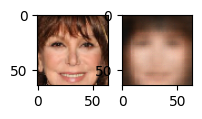

 14%|█▍        | 495/3434 [00:05<00:31, 94.48it/s]

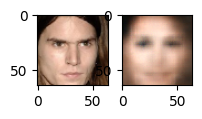

 29%|██▉       | 999/3434 [00:11<00:24, 97.66it/s]

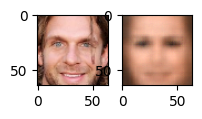

 44%|████▎     | 1499/3434 [00:17<00:20, 93.54it/s]

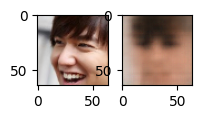

 58%|█████▊    | 1998/3434 [00:22<00:15, 93.30it/s]

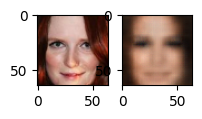

 73%|███████▎  | 2500/3434 [00:28<00:09, 93.72it/s]

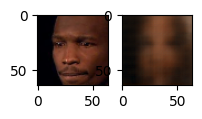

 87%|████████▋ | 2997/3434 [00:34<00:04, 96.05it/s]

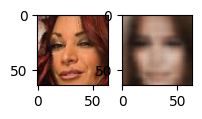

100%|██████████| 3434/3434 [00:39<00:00, 86.28it/s]
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : irrelevant_mollusk_7713
COMET INFO:     url                   : https://www.comet.com/jspark9703/6s191-lab2-part2-dbvae/5f6bcd043ca0461eb36499082f306831
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7555] : (0.04916467145085335, 0.9432821869850159)
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2Fjspark9703%2FdlearningStudy%2Fblob%2Fmain%2Flab2%2FPT_Part2_Debiasing.ipynb
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     latent_dim    : 100
COMET INFO:     learning_rate : 0.00

In [24]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=2,  # DB-VAE needs slightly more epochs to train
)

experiment = create_experiment("6S191_Lab2_Part2_DBVAE", params)

# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"]).to(device)
optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])


def debiasing_train_step(x, y):
    optimizer.zero_grad()

    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    '''TODO: call the DB_VAE loss function to compute the loss'''
    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO

    loss.backward()
    optimizer.step()

    return loss


# get training faces from data loader
all_faces = loader.get_all_train_faces()

# The training loop -- outer loop iterates over the number of epochs
step = 0
for i in range(params["num_epochs"]):
    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute data sampling proabilities
    p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO

    # get a batch of training data and compute the training step
    for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # load a batch of data
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # loss optimization
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        experiment.log_metric("loss", loss_value, step=step)

        # plot the progress every 200 steps
        if j % 500 == 0:
            mdl.util.plot_sample(x, y, dbvae, backend="pt")

        step += 1

experiment.end()

Wonderful! Now we should have a trained and (hopefully!) debiased facial classification model, ready for evaluation!

## 2.6 Evaluation of DB-VAE on Test Dataset

Finally let's test our DB-VAE model on the test dataset, looking specifically at its accuracy on each the "Dark Male", "Dark Female", "Light Male", and "Light Female" demographics. We will compare the performance of this debiased model against the (potentially biased) standard CNN from earlier in the lab.

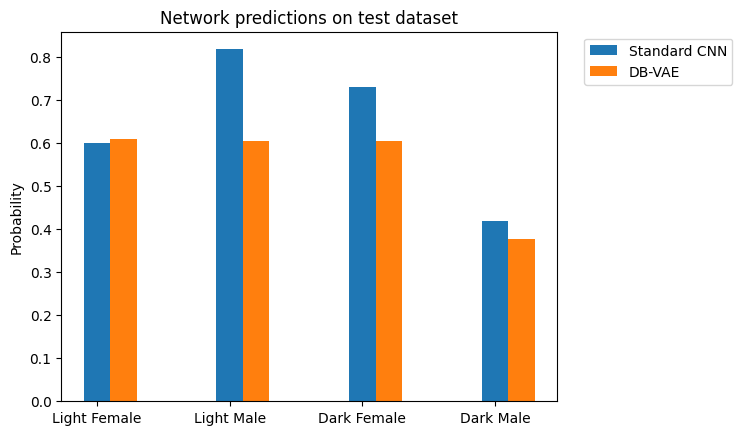

In [25]:
dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)

    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)

    dbvae_logits_list.append(logit.detach().cpu().numpy())

dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()

xx = np.arange(len(keys))

std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)

plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")

plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()

# twist


In [27]:
### 1. Modify debiasing_loss_function to support flexible beta ###
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma, beta=0.0005):
    y = y.float()
    face_indicator = (y == 1.0).float()

    vae_loss = vae_loss_function(x, x_pred, mu, logsigma, kl_weight=beta)

    classification_loss = F.binary_cross_entropy_with_logits(y_logit.squeeze(), y.squeeze())

    total_loss = torch.mean(classification_loss + face_indicator * vae_loss)

    return total_loss, classification_loss


### 2. Run training with multiple beta values and compare latent space PCA ###
beta_values = [0.001, 0.1, 1, 1.2]
beta_experiments = {}

for beta in beta_values:
    print(f"\n\n==== Training with beta={beta} ====")
    dbvae = DB_VAE(params["latent_dim"]).to(device)
    optimizer = optim.Adam(dbvae.parameters(), lr=params["learning_rate"])

    for epoch in range(params["num_epochs"]):
        print(f"Epoch {epoch+1}/{params['num_epochs']}")
        p_faces = get_training_sample_probabilities(all_faces, dbvae)

        for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
            x, y = loader.get_batch(params["batch_size"], p_pos=p_faces)
            x = torch.from_numpy(x).float().to(device)
            y = torch.from_numpy(y).float().to(device)

            optimizer.zero_grad()
            y_logit, z_mean, z_logsigma, x_recon = dbvae(x)
            loss, _ = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma, beta=beta)
            loss.backward()
            optimizer.step()

    # Store latent means for PCA analysis
    mu = get_latent_mu(all_faces, dbvae)
    beta_experiments[beta] = (mu, dbvae)







==== Training with beta=0.001 ====
Epoch 1/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:35<00:00, 97.41it/s]


Epoch 2/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:35<00:00, 96.39it/s] 




==== Training with beta=0.1 ====
Epoch 1/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:36<00:00, 94.59it/s]


Epoch 2/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:35<00:00, 96.78it/s] 




==== Training with beta=1 ====
Epoch 1/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:35<00:00, 96.61it/s] 


Epoch 2/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:38<00:00, 90.35it/s] 




==== Training with beta=1.2 ====
Epoch 1/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:37<00:00, 91.34it/s]


Epoch 2/2
Recomputing the sampling probabilities


100%|██████████| 3434/3434 [00:36<00:00, 94.79it/s] 


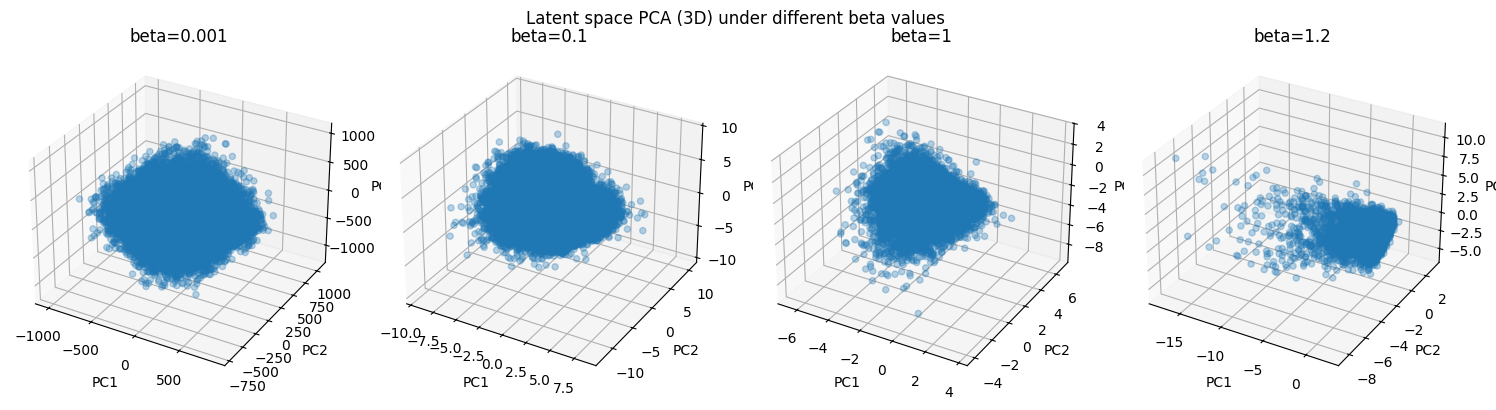

In [32]:
### 3. Visualize PCA for different beta values ###
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(15, 4))

for idx, (beta, values) in enumerate(beta_experiments.items()):
    if isinstance(values, tuple):
        mu = values[0]  # fallback if values is a tuple
    else:
        mu = values['mu']

    pca = PCA(n_components=3)
    proj = pca.fit_transform(mu)
    ax = fig.add_subplot(1, len(beta_experiments), idx + 1, projection='3d')
    ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], alpha=0.3)
    ax.set_title(f"beta={beta}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

fig.suptitle("Latent space PCA (3D) under different beta values")
plt.tight_layout()
plt.show()

In [2]:
def manipulate_latent(dbvae, image: np.ndarray, fixed_dim: int = 0, steps: int = 7, range_val: float = 3.0) -> None:
    """
    Visualizes changes in reconstruction by manipulating one latent dimension
    """
    dbvae.eval()
    with torch.no_grad():
        # Prepare single image
        x = torch.from_numpy(image).float().unsqueeze(0).to(next(dbvae.parameters()).device)
        if x.shape[-1] == 3:
            x = x.permute(0, 3, 1, 2)

        # Encode to latent mean
        _, z_mean, _, _ = dbvae(x)

        # Traverse one latent dimension
        z = z_mean.squeeze().cpu().numpy()
        values = np.linspace(-range_val, range_val, steps)
        manipulated_z = []

        for val in values:
            z_new = z.copy()
            z_new[fixed_dim] = val
            manipulated_z.append(torch.tensor(z_new).float())

        # Stack and decode
        z_batch = torch.stack(manipulated_z).to(next(dbvae.parameters()).device)
        recon = dbvae.decode(z_batch).cpu().numpy()

        # Plot
        fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))
        for i, ax in enumerate(axes):
            ax.imshow(np.transpose(recon[i], (1, 2, 0)))
            ax.set_title(f'z[{fixed_dim}]={values[i]:.1f}')
            ax.axis("off")
        plt.suptitle(f"Manipulating z[{fixed_dim}] across range", fontsize=14)
        plt.tight_layout()
        plt.show()
### 4. Visualize latent manipulation ###
# Choose the last trained model (with the highest beta)
dbvae = beta_experiments[beta_values[-1]][1]
test_face = all_faces[0]  # one test image
manipulate_latent(dbvae, test_face, fixed_dim=5, steps=7, range_val=2.5)

NameError: name 'np' is not defined

In [1]:
### 4. Visualize latent manipulation for all beta values ###
# Visualize the effect of manipulating one latent variable across all beta models
from matplotlib import pyplot as plt

test_face = all_faces[0]  # one test image to manipulate
fixed_dim = 5
steps = 10
range_val = 2.5

for beta in beta_values:
    if isinstance(beta_experiments[beta], tuple):
        dbvae = beta_experiments[beta][1]
    else:
        dbvae = beta_experiments[beta]['model']

    dbvae.eval()
    with torch.no_grad():
        x = torch.from_numpy(test_face).float().unsqueeze(0).to(next(dbvae.parameters()).device)
        if x.shape[-1] == 3:
            x = x.permute(0, 3, 1, 2)
        _, z_mean, _, _ = dbvae(x)
        z = z_mean.squeeze().cpu().numpy()
        values = np.linspace(-range_val, range_val, steps)
        manipulated_z = []
        for val in values:
            z_new = z.copy()
            z_new[fixed_dim] = val
            manipulated_z.append(torch.tensor(z_new).float())
        z_batch = torch.stack(manipulated_z).to(next(dbvae.parameters()).device)
        recon = dbvae.decode(z_batch).cpu().numpy()

        fig, axes = plt.subplots(1, steps, figsize=(steps * 2, 2))
        for i, ax in enumerate(axes):
            ax.imshow(np.transpose(recon[i], (1, 2, 0)))
            ax.set_title(f'{values[i]:.1f}')
            ax.axis("off")
        plt.suptitle(f"Latent dim {fixed_dim} traversal (β={beta})", fontsize=14)
        plt.tight_layout()
        plt.show()

NameError: name 'all_faces' is not defined

In [ ]:
### 5. Group fairness evaluation + histogram ###
xx = np.arange(len(keys))
std_probs_mean = standard_classifier_probs.mean(axis=1)

plt.figure(figsize=(10, 4))
for i, beta in enumerate(beta_values):
    dbvae_probs_mean = beta_experiments[beta]['probs'].reshape(len(keys), -1).mean(axis=1)
    plt.bar(xx + i * 0.2, dbvae_probs_mean, width=0.2, label=f"DB-VAE β={beta}")

plt.bar(xx - 0.2, std_probs_mean, width=0.2, label="Standard CNN")
plt.xticks(xx, keys)
plt.title("Network predictions on test dataset by group")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()

# KL histogram
plt.figure(figsize=(12, 3))
for idx, (beta, values) in enumerate(beta_experiments.items()):
    mu = values['mu']
    kl = np.mean(0.5 * np.sum(mu**2, axis=1))  # approximation of KL assuming std~1
    plt.subplot(1, len(beta_values), idx + 1)
    plt.hist(np.sum(mu**2, axis=1), bins=30, alpha=0.7)
    plt.title(f"β={beta} KL≈{kl:.2f}")
    plt.xlabel("KL divergence")

plt.suptitle("Latent KL divergence distributions")
plt.tight_layout()
plt.show()